# Intro 
Data augmentation is a technique in machine learning used to reduce overfitting when training a machine learning model,by training models on several slightly-modified copies of existing data.
When convolutional neural networks grew larger in mid-1990s, there often was not enough available data to train them, especially considering that some part of the overall dataset should be spared for later testing. It was proposed to perturb existing data with affine transformations to create new examples with the same labels, which were complemented by so-called elastic distortions in 2003,and the technique was widely used as of 2010s.

# 1. Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt


# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=12, titlepad=10)
plt.rc('image', cmap='magma')


print("Import is completed successfully.")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Import is completed successfully.


# 2. Load trainig and validation image datasets
We will use a modified cars196 dataset used in Kaggle's Computer Vision course for classification.

In [2]:
# Load training and validation sets
ds_train = image_dataset_from_directory(
    directory='/kaggle/input/car-or-truck/train',  #path to the train dataset
    labels='inferred',                             #labels 0 or 1  for image from directory
    label_mode='binary',                           #labels are generated from the directory structure
    image_size=[128,128],
    batch_size=64,                                  #size of the batches of data
    interpolation='nearest',                        #the interpolation method used when resizing images
    shuffle=True)

ds_valid = image_dataset_from_directory(
    directory='/kaggle/input/car-or-truck/valid',  #path to the valid dataset
    labels='inferred',                             #labels 0 or 1  for image from directory
    label_mode='binary',                           #labels are generated from the directory structure
    image_size=[128,128],
    batch_size=64,                                 #size of the batches of data
    interpolation='nearest',                       #the interpolation method used when resizing images
    shuffle=False)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


# 3. Create Image Data Pipeline

In [3]:
#Convert image to dtype tf.float32 (from 0 to 1)
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = (
    ds_train
    .map(convert_to_float)  #mapping
    .cache() 
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid
    .map(convert_to_float)
    .cache() #cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.
    .prefetch(buffer_size=AUTOTUNE) #Prefetch overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. 
)
print('Done')

Done


# 4. Explore Augmentation
Run the cell again if you'd like to get a new random image from training dataset with augmentation

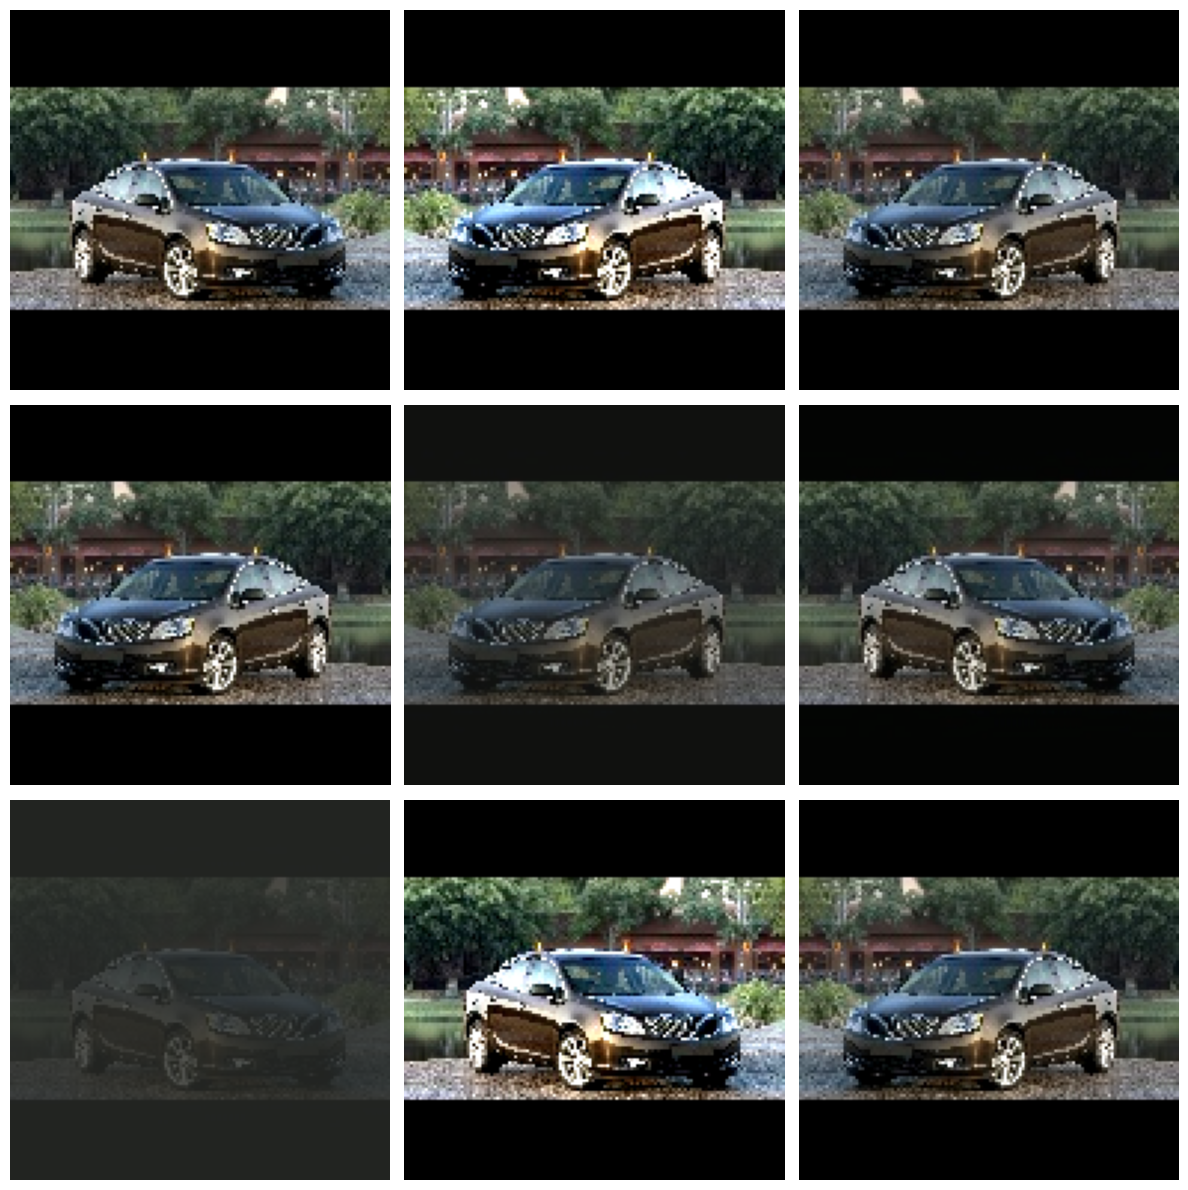

In [4]:
# all of the "factor" parameters indicate a percent-change
augmentation = keras.Sequential([
#preprocessing.RandomWidth(factor=0.2), # horizontal stretch
preprocessing.RandomContrast(factor=0.9),
#preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
#preprocessing.RandomRotation(factor=0.20),
#preprocessing.RandomTranslation(height_factor=0.5, width_factor=0.5),
])

next_one = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(12,12))
for i in range(9):
    image = augmentation(next_one, training=True)
    plt.subplot(3, 3, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

# 5. Define models
Define First Model.

In [ ]:
model_01 = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),

    # Augmentation
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),
   

    # The First block
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # The Second block
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # The Third block
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head of CNN
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

Define Second Model.

In [ ]:
model_02 = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),

    # Augmentation
    preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='vertical'),
    preprocessing.RandomRotation(factor=0.5),
   
    # The First block
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=2, activation='selu', padding='valid'),
    layers.MaxPool2D(),

    # The Second block
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=2, activation='selu', padding='valid'),
    layers.MaxPool2D(),

    # The Third block
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=2, activation='selu', padding='valid'),
    layers.Conv2D(filters=256, kernel_size=2, activation='selu', padding='valid'),
    layers.MaxPool2D(),

    # Head of CNN
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(6, activation='selu'),
    layers.Dense(1, activation='sigmoid'),
])

# 6. Compile and Train models
It may take quite a few epochs to complete the training of models, so for convenience we will include a callback for an early stop.

In [ ]:
optimizer_1 = tf.keras.optimizers.Adam(epsilon=0.01)

model_01.compile(
    optimizer = optimizer_1,
    loss = 'binary_crossentropy',
    metrics =  ['binary_accuracy'])

history_01 = model_01.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=40,
    verbose=True
)


In [ ]:
optimizer_2 = tf.keras.optimizers.Adam(epsilon=0.01)

model_02.compile(
    optimizer = optimizer_2,
    loss = 'binary_crossentropy',
    metrics =  ['binary_accuracy'])

history_02 = model_02.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=40,
    verbose=True
)

# 6. Examine the loss and metric plots

For the First Model:





In [ ]:
history_frame_01 = pd.DataFrame(history_01.history)
history_frame_01.loc[:, ['loss', 'val_loss']].plot()
history_frame_01.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

print(("Best Validation Loss for Model 1: {:0.4f}" +\
      "\nBest Validation Accuracy for Model 1: {:0.4f}")\
      .format(history_frame_01['val_loss'].min(), 
              history_frame_01['val_binary_accuracy'].max()))

For the Second Model:

In [ ]:
history_frame_02 = pd.DataFrame(history_02.history)
history_frame_02.loc[:, ['loss', 'val_loss']].plot()
history_frame_02.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

print(("Best Validation Loss for Model 2: {:0.4f}" +\
      "\nBest Validation Accuracy for Model 2: {:0.4f}")\
      .format(history_frame_02['val_loss'].min(), 
              history_frame_02['val_binary_accuracy'].max()))

**References**

1.  Shorten, Connor; Khoshgoftaar, Taghi M. "A survey on Image Data Augmentation for Deep Learning". Mathematics and Computers in Simulation. springer. 6: 60. 
2.  Yann Lecun; et al. Learning algorithms for classification: A comparison on handwritten digit recognition (Conference paper). World Scientific. pp. 261–276. 
3.  Simard, P.Y.; Steinkraus, D.; Platt, J.C. (2003). "Best practices for convolutional neural networks applied to visual document analysis". Seventh International Conference on Document Analysis and Recognition, 2003. Proceedings. Vol. 1. pp. 958–963. 